In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install pyspark

In [ ]:
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
import matplotlib.pyplot as plt
from pyspark.sql.functions import sum, when
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
import seaborn as sns

In [ ]:
spark = SparkSession.builder.appName('uas').getOrCreate()
df = spark.read.csv('/content/drive/MyDrive/UAS_BD/cardio_data_processed.csv', header = True, inferSchema = True)
df.printSchema()

root
 |-- id: integer (nullable = true)
 |-- age: integer (nullable = true)
 |-- gender: integer (nullable = true)
 |-- height: integer (nullable = true)
 |-- weight: double (nullable = true)
 |-- ap_hi: integer (nullable = true)
 |-- ap_lo: integer (nullable = true)
 |-- cholesterol: integer (nullable = true)
 |-- gluc: integer (nullable = true)
 |-- smoke: integer (nullable = true)
 |-- alco: integer (nullable = true)
 |-- active: integer (nullable = true)
 |-- cardio: integer (nullable = true)
 |-- age_years: integer (nullable = true)
 |-- bmi: double (nullable = true)
 |-- bp_category: string (nullable = true)
 |-- bp_category_encoded: string (nullable = true)



In [ ]:
df.show()

+---+-----+------+------+------+-----+-----+-----------+----+-----+----+------+------+---------+------------------+--------------------+--------------------+
| id|  age|gender|height|weight|ap_hi|ap_lo|cholesterol|gluc|smoke|alco|active|cardio|age_years|               bmi|         bp_category| bp_category_encoded|
+---+-----+------+------+------+-----+-----+-----------+----+-----+----+------+------+---------+------------------+--------------------+--------------------+
|  0|18393|     2|   168|  62.0|  110|   80|          1|   1|    0|   0|     1|     0|       50|  21.9671201814059|Hypertension Stage 1|Hypertension Stage 1|
|  1|20228|     1|   156|  85.0|  140|   90|          3|   1|    0|   0|     1|     1|       55|34.927679158448385|Hypertension Stage 2|Hypertension Stage 2|
|  2|18857|     1|   165|  64.0|  130|   70|          3|   1|    0|   0|     0|     1|       51|23.507805325987146|Hypertension Stage 1|Hypertension Stage 1|
|  3|17623|     2|   169|  82.0|  150|  100|        

In [ ]:
from pyspark.ml.feature import StringIndexer

indexer_bp_category = StringIndexer(inputCol="bp_category", outputCol="bp_category_index").fit(df)
df = indexer_bp_category.transform(df)

indexer_bp_category_encoded = StringIndexer(inputCol="bp_category_encoded", outputCol="bp_category_encoded_index").fit(df)
df = indexer_bp_category_encoded.transform(df)

# Convert to integer
df = df.withColumn("bp_category_index", col("bp_category_index").cast("int"))
df = df.withColumn("bp_category_encoded_index", col("bp_category_encoded_index").cast("int"))

df = df.drop("bp_category", "bp_category_encoded")

df.show()


+---+-----+------+------+------+-----+-----+-----------+----+-----+----+------+------+---------+------------------+-----------------+-------------------------+
| id|  age|gender|height|weight|ap_hi|ap_lo|cholesterol|gluc|smoke|alco|active|cardio|age_years|               bmi|bp_category_index|bp_category_encoded_index|
+---+-----+------+------+------+-----+-----+-----------+----+-----+----+------+------+---------+------------------+-----------------+-------------------------+
|  0|18393|     2|   168|  62.0|  110|   80|          1|   1|    0|   0|     1|     0|       50|  21.9671201814059|                0|                        0|
|  1|20228|     1|   156|  85.0|  140|   90|          3|   1|    0|   0|     1|     1|       55|34.927679158448385|                1|                        1|
|  2|18857|     1|   165|  64.0|  130|   70|          3|   1|    0|   0|     0|     1|       51|23.507805325987146|                0|                        0|
|  3|17623|     2|   169|  82.0|  150|  

In [ ]:
pd.DataFrame(df.take(10), columns=df.columns).transpose()

,0,1,2,3,4,5,6,7,8,9
id,0.00000,1.000000,2.000000,3.000000,4.000000,8.000000,9.000000,12.000000,13.000000,14.00000
age,18393.00000,20228.000000,18857.000000,17623.000000,17474.000000,21914.000000,22113.000000,22584.000000,17668.000000,19834.00000
gender,2.00000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,2.000000,1.000000,1.00000
height,168.00000,156.000000,165.000000,169.000000,156.000000,151.000000,157.000000,178.000000,158.000000,164.00000
weight,62.00000,85.000000,64.000000,82.000000,56.000000,67.000000,93.000000,95.000000,71.000000,68.00000
ap_hi,110.00000,140.000000,130.000000,150.000000,100.000000,120.000000,130.000000,130.000000,110.000000,110.00000
ap_lo,80.00000,90.000000,70.000000,100.000000,60.000000,80.000000,80.000000,90.000000,70.000000,60.00000
cholesterol,1.00000,3.000000,3.000000,1.000000,1.000000,2.000000,3.000000,3.000000,1.000000,1.00000
gluc,1.00000,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,3.000000,1.000000,1.00000
smoke,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000


In [ ]:
# ambil kolom yang memiliki fitur numerik
numeric_features = [t[0] for t in df.dtypes if t[1]]
numeric_summary = df.select(numeric_features).summary()
numeric_summary.show(truncate=False)

+-------+------------------+-----------------+------------------+------------------+------------------+------------------+-----------------+------------------+------------------+-------------------+--------------------+------------------+-------------------+------------------+------------------+------------------+-------------------------+
|summary|id                |age              |gender            |height            |weight            |ap_hi             |ap_lo            |cholesterol       |gluc              |smoke              |alco                |active            |cardio             |age_years         |bmi               |bp_category_index |bp_category_encoded_index|
+-------+------------------+-----------------+------------------+------------------+------------------+------------------+-----------------+------------------+------------------+-------------------+--------------------+------------------+-------------------+------------------+------------------+------------------+-

In [ ]:
df = df.drop("bp_category_index")

df.show()

+---+-----+------+------+------+-----+-----+-----------+----+-----+----+------+------+---------+------------------+-------------------------+
| id|  age|gender|height|weight|ap_hi|ap_lo|cholesterol|gluc|smoke|alco|active|cardio|age_years|               bmi|bp_category_encoded_index|
+---+-----+------+------+------+-----+-----+-----------+----+-----+----+------+------+---------+------------------+-------------------------+
|  0|18393|     2|   168|  62.0|  110|   80|          1|   1|    0|   0|     1|     0|       50|  21.9671201814059|                        0|
|  1|20228|     1|   156|  85.0|  140|   90|          3|   1|    0|   0|     1|     1|       55|34.927679158448385|                        1|
|  2|18857|     1|   165|  64.0|  130|   70|          3|   1|    0|   0|     0|     1|       51|23.507805325987146|                        0|
|  3|17623|     2|   169|  82.0|  150|  100|          1|   1|    0|   0|     1|     1|       48| 28.71047932495361|                        1|
|  4|1

In [ ]:
missing_values = df.select([col(c).alias(c) for c in df.columns]).na.fill(0).agg(*[sum(col(c).isNull().cast("int")).alias(c) for c in df.columns])

# Menampilkan hasil missing value
print("Jumlah nilai-nilai yang hilang pada setiap kolom:")
missing_values.show(truncate=False)

Jumlah nilai-nilai yang hilang pada setiap kolom:
+---+---+------+------+------+-----+-----+-----------+----+-----+----+------+------+---------+---+-------------------------+
|id |age|gender|height|weight|ap_hi|ap_lo|cholesterol|gluc|smoke|alco|active|cardio|age_years|bmi|bp_category_encoded_index|
+---+---+------+------+------+-----+-----+-----------+----+-----+----+------+------+---------+---+-------------------------+
|0  |0  |0     |0     |0     |0    |0    |0          |0   |0    |0   |0     |0     |0        |0  |0                        |
+---+---+------+------+------+-----+-----+-----------+----+-----+----+------+------+---------+---+-------------------------+



In [ ]:
cardio_sum = df.groupBy('cardio').count()

# Menampilkan hasil
print("Jumlah kemunculan setiap nilai pada kolom 'cardio':")
cardio_sum.show()

Jumlah kemunculan setiap nilai pada kolom 'cardio':
+------+-----+
|cardio|count|
+------+-----+
|     1|33672|
|     0|34533|
+------+-----+



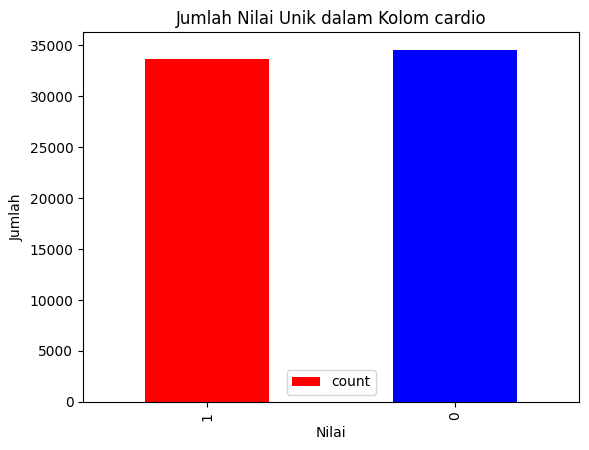

In [ ]:
cardio_counts_pd = cardio_sum.toPandas()

# Plot bar chart
cardio_counts_pd.plot(kind='bar', x='cardio', y='count', color=['red', 'blue'])
plt.title('Jumlah Nilai Unik dalam Kolom cardio')
plt.xlabel('Nilai')
plt.ylabel('Jumlah')
plt.show()

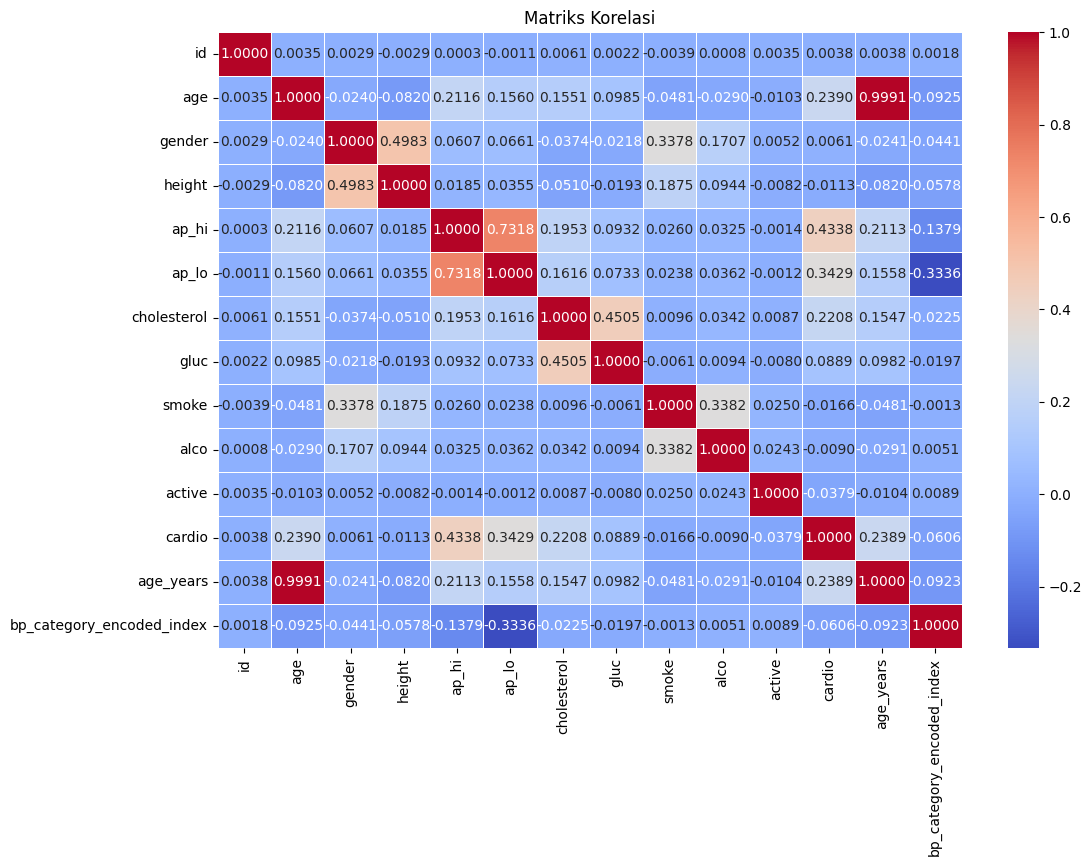

In [ ]:
integer_columns = [col_name for col_name, col_type in df.dtypes if col_type == 'int']


vector_assembler = VectorAssembler(inputCols=integer_columns, outputCol="features")
df_assembled = vector_assembler.transform(df).select("features")


matrix = Correlation.corr(df_assembled, "features").head()
correlation_matrix = matrix[0].toArray()


column_names = df_assembled.schema["features"].metadata["ml_attr"]["attrs"]["numeric"]


plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".4f", linewidths=.5,
            xticklabels=[col["name"] for col in column_names], yticklabels=[col["name"] for col in column_names])
plt.title("Matriks Korelasi")
plt.show()

In [ ]:
# drop unrelated table
df = df.drop('id')
df

DataFrame[age: int, gender: int, height: int, weight: double, ap_hi: int, ap_lo: int, cholesterol: int, gluc: int, smoke: int, alco: int, active: int, cardio: int, age_years: int, bmi: double, bp_category_encoded_index: int]

In [ ]:
output_path = "/content/drive/MyDrive/UAS_BD/combined_output"
df.coalesce(1).write.option("header", "true").mode("overwrite").csv(output_path)

Logistic Regresion


In [ ]:
# Nama kolom-kolom
#feature_columns = [col for col in df.columns if col != 'stress_level']
feature_columns = ['cholesterol', 'gluc','ap_lo','ap_hi','gender', 'age','bp_category_encoded_index']

# Pisahkan fitur dan label
assembler = VectorAssembler(inputCols=feature_columns, outputCol='features')
df = assembler.transform(df).select('features', 'cardio')

# Tampilkan hasil
df.show(truncate=False)

+-------------------------------------+------+
|features                             |cardio|
+-------------------------------------+------+
|[1.0,1.0,80.0,110.0,2.0,18393.0,0.0] |0     |
|[3.0,1.0,90.0,140.0,1.0,20228.0,1.0] |1     |
|[3.0,1.0,70.0,130.0,1.0,18857.0,0.0] |1     |
|[1.0,1.0,100.0,150.0,2.0,17623.0,1.0]|1     |
|[1.0,1.0,60.0,100.0,1.0,17474.0,2.0] |0     |
|[2.0,2.0,80.0,120.0,1.0,21914.0,0.0] |0     |
|[3.0,1.0,80.0,130.0,1.0,22113.0,0.0] |0     |
|[3.0,3.0,90.0,130.0,2.0,22584.0,0.0] |1     |
|[1.0,1.0,70.0,110.0,1.0,17668.0,2.0] |0     |
|[1.0,1.0,60.0,110.0,1.0,19834.0,2.0] |0     |
|[1.0,1.0,80.0,120.0,1.0,22530.0,0.0] |0     |
|[1.0,1.0,80.0,120.0,2.0,18815.0,0.0] |0     |
|[1.0,1.0,80.0,120.0,2.0,14791.0,0.0] |0     |
|[1.0,1.0,70.0,110.0,1.0,19809.0,2.0] |0     |
|[1.0,1.0,90.0,130.0,2.0,14532.0,0.0] |0     |
|[1.0,1.0,80.0,120.0,2.0,16782.0,0.0] |1     |
|[1.0,1.0,70.0,130.0,1.0,21296.0,0.0] |0     |
|[1.0,3.0,70.0,110.0,1.0,16747.0,2.0] |0     |
|[1.0,1.0,70.

In [ ]:
train, test = df.randomSplit([0.8, 0.2], seed = 5)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 54497
Test Dataset Count: 13708


In [ ]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import LogisticRegression

df = LogisticRegression(featuresCol = 'features', labelCol = 'cardio', maxIter=3)
dfModel = df.fit(train)

predictions = dfModel.transform(test)

# Inisialisasi evaluator akurasi
evaluator_accuracy = MulticlassClassificationEvaluator(
    labelCol='cardio',
    predictionCol='prediction',
    metricName='accuracy'
)

# Evaluasi akurasi
accuracy = evaluator_accuracy.evaluate(predictions)
print(f'Test Accuracy: {accuracy:.2%}')

# Inisialisasi evaluator F1-score
evaluator_f1 = MulticlassClassificationEvaluator(
    labelCol='cardio',
    predictionCol='prediction',
    metricName='f1'
)

# Evaluasi F1-score
f1_score = evaluator_f1.evaluate(predictions)
print(f'Test F1-Score: {f1_score:.2%}')

# Filter prediksi yang salah
wrong_predictions = predictions.filter(col('cardio') != col('prediction'))

# Tampilkan hasil
wrong_predictions.select('features', 'cardio', 'rawPrediction', 'prediction', 'probability').show(10)

# Hitung jumlah prediksi yang salah
count_wrong_predictions = wrong_predictions.count()
print(f'Jumlah prediksi yang salah: {count_wrong_predictions}')

Test Accuracy: 72.09%
Test F1-Score: 71.92%
+--------------------+------+--------------------+----------+--------------------+
|            features|cardio|       rawPrediction|prediction|         probability|
+--------------------+------+--------------------+----------+--------------------+
|[1.0,1.0,60.0,90....|     1|[2.77179727817549...|       0.0|[0.94113263831334...|
|[1.0,1.0,60.0,90....|     1|[2.76666845077977...|       0.0|[0.94084784732810...|
|[1.0,1.0,60.0,90....|     1|[2.41571011898709...|       0.0|[0.91801746050443...|
|[1.0,1.0,60.0,90....|     1|[2.10343779955069...|       0.0|[0.89123686596382...|
|[1.0,1.0,60.0,90....|     1|[1.92129115803992...|       0.0|[0.87228234540150...|
|[1.0,1.0,60.0,90....|     1|[1.72874032381212...|       0.0|[0.84925122293383...|
|[1.0,1.0,60.0,90....|     1|[2.45607582601001...|       0.0|[0.92100463042034...|
|[1.0,1.0,60.0,90....|     1|[2.03199506934696...|       0.0|[0.88411563980614...|
|[1.0,1.0,60.0,100...|     1|[2.21884888336

/usr/local/lib/python3.11/dist-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


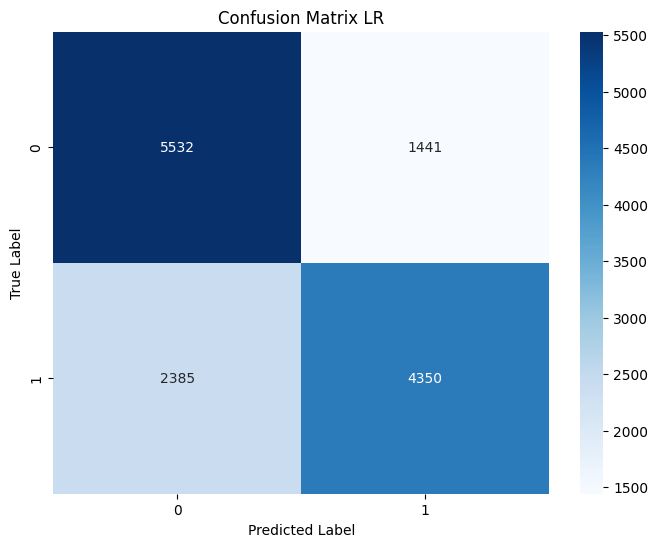

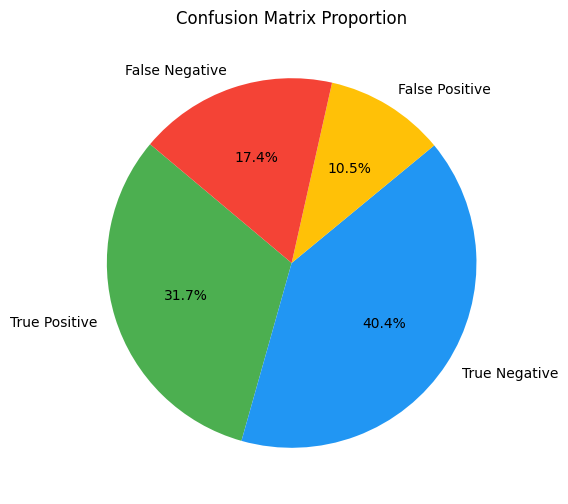

In [ ]:
from pyspark.mllib.evaluation import MulticlassMetrics

prediction_and_labels = predictions.select('prediction', 'cardio').rdd.map(lambda row: (float(row['prediction']), float(row['cardio'])))

# Inisialisasi MulticlassMetrics
metrics = MulticlassMetrics(prediction_and_labels)

# Ambil confusion matrix sebagai array
confusion_matrix = metrics.confusionMatrix().toArray()

# Konversi confusion matrix ke tipe data integer
confusion_matrix = confusion_matrix.astype(int)

# Tampilkan confusion matrix menggunakan seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=[0, 1], yticklabels=[0, 1])
plt.title('Confusion Matrix LR')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

true_positive = confusion_matrix[1, 1]
true_negative = confusion_matrix[0, 0]
false_positive = confusion_matrix[0, 1]
false_negative = confusion_matrix[1, 0]

labels = ['True Positive', 'True Negative', 'False Positive', 'False Negative']
sizes = [true_positive, true_negative, false_positive, false_negative]
colors = ['#4CAF50', '#2196F3', '#FFC107', '#F44336']

# Tampilkan pie chart
plt.figure(figsize=(8, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=colors)
plt.title('Confusion Matrix Proportion')
plt.show()

DT

In [ ]:
from pyspark.sql import SparkSession

lcprepose = spark.read.csv('/content/drive/MyDrive/UAS_BD/combined_output/part-00000-dac3d7a2-f738-4845-8fd5-0a0a321d9370-c000.csv', header=True, inferSchema=True)

kolom_fitur = ['cholesterol', 'gluc','ap_lo','ap_hi','gender', 'age','bp_category_encoded_index']

In [ ]:
from pyspark.ml import Pipeline
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Assuming lcprepose is your DataFrame with columns including 'Outcome'
feature_columns = ['cholesterol', 'gluc', 'ap_lo', 'ap_hi', 'gender', 'age', 'bp_category_encoded_index']

# Using VectorAssembler to combine features into a single vector column
assembler = VectorAssembler(inputCols=feature_columns, outputCol='features')

# Initialize DecisionTreeClassifier
dt = DecisionTreeClassifier(labelCol='cardio', featuresCol='features')

# Create a pipeline with the assembler and DecisionTreeClassifier
pipeline = Pipeline(stages=[assembler, dt])

# Split the data into train and test sets
train2, test_data = lcprepose.randomSplit([0.8, 0.2], seed=5)

# Train the model using the train data
model = pipeline.fit(train2)


# Make predictions on the test data
predictions = model.transform(test_data)

# Evaluate the model using MulticlassClassificationEvaluator for accuracy
evaluator_accuracy = MulticlassClassificationEvaluator(
    labelCol='cardio',
    predictionCol='prediction',
    metricName='accuracy'
)

# Measure accuracy
accuracy = evaluator_accuracy.evaluate(predictions)
print(f'Test Accuracy: {accuracy:.2%}')

# Evaluate the model using F1-Score
evaluator_f1 = MulticlassClassificationEvaluator(
    labelCol='cardio',
    predictionCol='prediction',
    metricName='f1'
)

# Measure F1-Score
f1_score = evaluator_f1.evaluate(predictions)
print(f'Test F1-Score: {f1_score:.2%}')

# Display prediction results
predictions.select('features', 'cardio', 'rawPrediction', 'prediction', 'probability').show(10)


Test Accuracy: 72.24%
Test F1-Score: 72.13%
+--------------------+------+----------------+----------+--------------------+
|            features|cardio|   rawPrediction|prediction|         probability|
+--------------------+------+----------------+----------+--------------------+
|[3.0,3.0,80.0,100...|     0|     [80.0,27.0]|       0.0|[0.74766355140186...|
|[1.0,1.0,90.0,140...|     0| [1430.0,6284.0]|       1.0|[0.18537723619393...|
|[3.0,3.0,80.0,120...|     1|   [199.0,200.0]|       1.0|[0.49874686716791...|
|[1.0,1.0,80.0,120...|     0|[15211.0,4355.0]|       0.0|[0.77742001431053...|
|[1.0,1.0,70.0,110...|     0|[15211.0,4355.0]|       0.0|[0.77742001431053...|
|[2.0,1.0,85.0,120...|     0|[15211.0,4355.0]|       0.0|[0.77742001431053...|
|[1.0,1.0,80.0,120...|     1|[15211.0,4355.0]|       0.0|[0.77742001431053...|
|[1.0,1.0,80.0,120...|     0|[15211.0,4355.0]|       0.0|[0.77742001431053...|
|[1.0,2.0,70.0,120...|     1|[15211.0,4355.0]|       0.0|[0.77742001431053...|
|[1.0,1.

In [ ]:
model = pipeline.fit(train2)

In [ ]:
predictionsDTC = model.transform(train2)
predictionsDTC = predictionsDTC.withColumn('cardio', col('cardio').cast('double'))

/usr/local/lib/python3.11/dist-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


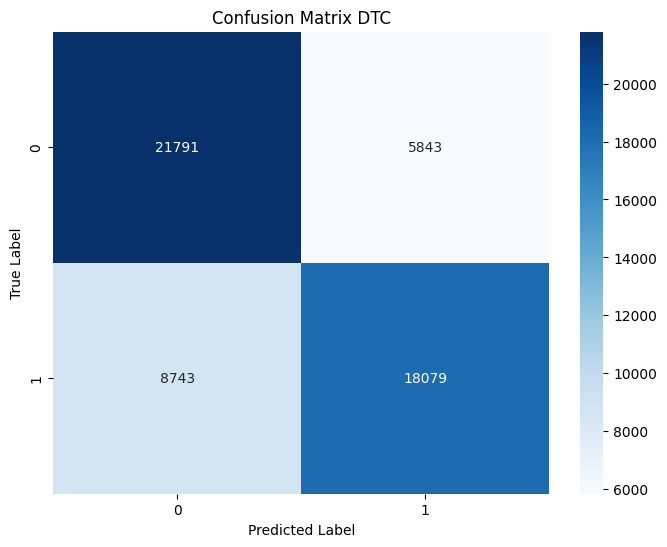

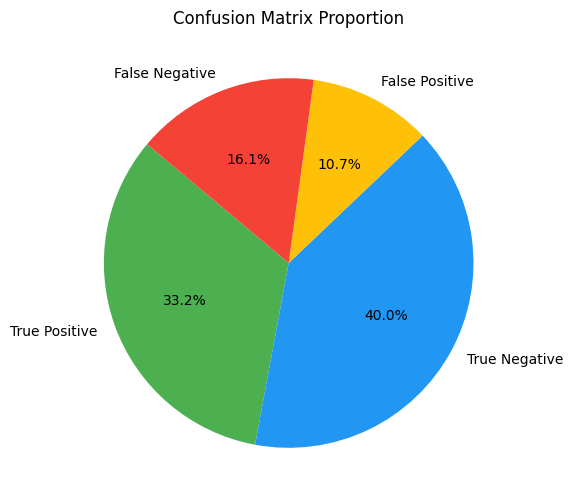

In [ ]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.sql.functions import col

# Cast 'Outcome' column to DoubleType
predictionsDTC = predictionsDTC.withColumn('cardio', col('cardio').cast('double'))

# Mengambil kolom label dan prediksi sebagai RDD untuk MulticlassMetrics
predictionAndLabelsDTC = predictionsDTC.select('prediction', 'cardio').rdd

# Inisialisasi MulticlassMetrics
metricsDTC = MulticlassMetrics(predictionAndLabelsDTC)

# Mendapatkan matriks konfusi
confusion_matrixDTC = metricsDTC.confusionMatrix().toArray()

# Konversi matriks konfusi menjadi DataFrame
confusion_matrix_DTC = pd.DataFrame(confusion_matrixDTC, columns=[str(i) for i in range(confusion_matrixDTC.shape[1])])

# Plot confusion matrix menggunakan seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix_DTC, annot=True, fmt="g", cmap="Blues", xticklabels=[0, 1], yticklabels=[0, 1])
plt.title('Confusion Matrix DTC')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

true_positive = int(confusion_matrix_DTC.iloc[1, 1])
true_negative = int(confusion_matrix_DTC.iloc[0, 0])
false_positive = int(confusion_matrix_DTC.iloc[0, 1])
false_negative = int(confusion_matrix_DTC.iloc[1, 0])

labels = ['True Positive', 'True Negative', 'False Positive', 'False Negative']
sizes = [true_positive, true_negative, false_positive, false_negative]
colors = ['#4CAF50', '#2196F3', '#FFC107', '#F44336']

# Tampilkan pie chart
plt.figure(figsize=(8, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=colors)
plt.title('Confusion Matrix Proportion')
plt.show()

RF

In [ ]:
from pyspark.ml.classification import RandomForestClassifier
# Inisialisasi model Random Forest
rf = RandomForestClassifier(labelCol="cardio", featuresCol="features", numTrees=10)

# Pipeline
pipeline_rf = Pipeline(stages=[assembler, rf])

# Train model
model_rf = pipeline_rf.fit(train2)

# Make predictions
predictionRFC = model_rf.transform(train2)

# Evaluate accuracy
evaluator_accuracy_rf = MulticlassClassificationEvaluator(
    labelCol='cardio',
    predictionCol='prediction',
    metricName='accuracy'
)

# Evaluate F1-Score
evaluator_f1_rf = MulticlassClassificationEvaluator(
    labelCol='cardio',
    predictionCol='prediction',
    metricName='f1'
)

# Accuracy
accuracy_rf = evaluator_accuracy_rf.evaluate(predictionRFC)
print(f'Test Accuracy: {accuracy_rf:.2%}')

# F1-Score
f1_score_rf = evaluator_f1_rf.evaluate(predictionRFC)
print(f'Test F1-Score: {f1_score_rf:.2%}')

predictionRFC.select('features', 'cardio', 'rawPrediction', 'prediction', 'probability').show(10)

Test Accuracy: 72.66%
Test F1-Score: 72.56%
+--------------------+------+--------------------+----------+--------------------+
|            features|cardio|       rawPrediction|prediction|         probability|
+--------------------+------+--------------------+----------+--------------------+
|[1.0,1.0,60.0,100...|     0|[7.80427275981048...|       0.0|[0.78042727598104...|
|[1.0,1.0,80.0,120...|     0|[7.38917311898648...|       0.0|[0.73891731189864...|
|[1.0,1.0,80.0,120...|     0|[7.38917311898648...|       0.0|[0.73891731189864...|
|[1.0,1.0,70.0,110...|     0|[7.85477535792228...|       0.0|[0.78547753579222...|
|[3.0,3.0,110.0,15...|     1|[1.89694627532058...|       1.0|[0.18969462753205...|
|[1.0,2.0,100.0,15...|     1|[1.88856480591738...|       1.0|[0.18885648059173...|
|[2.0,1.0,80.0,110...|     0|[7.16796352821639...|       0.0|[0.71679635282163...|
|[1.0,1.0,80.0,140...|     1|[2.61201254917033...|       1.0|[0.26120125491703...|
|[1.0,1.0,70.0,110...|     0|[7.85477535792

/usr/local/lib/python3.11/dist-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


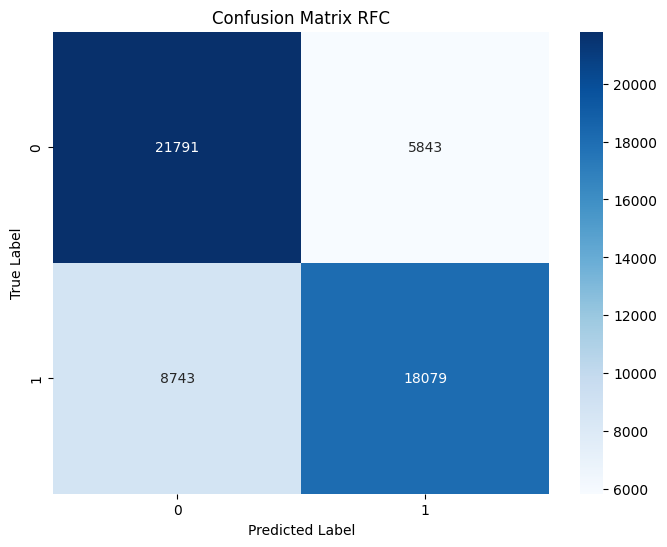

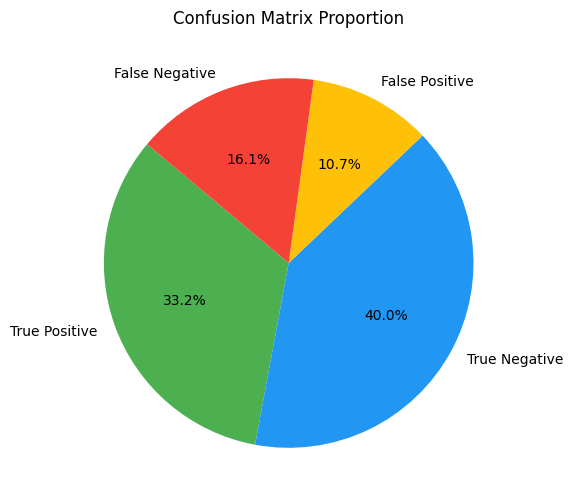

In [ ]:
# Cast 'Outcome' column to DoubleType
predictionsRFC = predictionRFC.withColumn('cardio', col('cardio').cast('double'))

# Mengambil kolom label dan prediksi sebagai RDD untuk MulticlassMetrics
predictionAndLabelsRFC = predictionsRFC.select('prediction', 'cardio').rdd

# Inisialisasi MulticlassMetrics
metricsRFC = MulticlassMetrics(predictionAndLabelsDTC)

# Mendapatkan matriks konfusi
confusion_matrixRFC = metricsRFC.confusionMatrix().toArray()

# Konversi matriks konfusi menjadi DataFrame
confusion_matrix_RFC = pd.DataFrame(confusion_matrixRFC, columns=[str(i) for i in range(confusion_matrixRFC.shape[1])])

# Plot confusion matrix menggunakan seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix_RFC, annot=True, fmt="g", cmap="Blues", xticklabels=[0, 1], yticklabels=[0, 1])
plt.title('Confusion Matrix RFC')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

true_positive = int(confusion_matrix_RFC.iloc[1, 1])
true_negative = int(confusion_matrix_RFC.iloc[0, 0])
false_positive = int(confusion_matrix_RFC.iloc[0, 1])
false_negative = int(confusion_matrix_RFC.iloc[1, 0])
labels = ['True Positive', 'True Negative', 'False Positive', 'False Negative']
sizes = [true_positive, true_negative, false_positive, false_negative]
colors = ['#4CAF50', '#2196F3', '#FFC107', '#F44336']

# Tampilkan pie chart
plt.figure(figsize=(8, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=colors)
plt.title('Confusion Matrix Proportion')
plt.show()

GBT

In [ ]:
from pyspark.ml.classification import GBTClassifier
from pyspark.ml import Pipeline

# Inisialisasi GBTClassifier
gbt = GBTClassifier(labelCol="cardio", featuresCol="features", maxIter=10)

# Pipeline
pipeline_gbt = Pipeline(stages=[assembler, gbt])

# Train model
model_gbt = pipeline_gbt.fit(train2)

# Melakukan prediksi pada test data
prediction_gbt = model_gbt.transform(train2)

# Evaluasi model menggunakan MulticlassClassificationEvaluator
evaluator_accuracy_gbt = MulticlassClassificationEvaluator(
    labelCol='cardio',
    predictionCol='prediction',
    metricName='accuracy'
)

# Evaluasi F1-Score
evaluator_f1_gbt = MulticlassClassificationEvaluator(
    labelCol='cardio',
    predictionCol='prediction',
    metricName='f1'
)

# Accuracy
accuracy_gbt = evaluator_accuracy_gbt.evaluate(prediction_gbt)
print(f'Test Accuracy: {accuracy_gbt:.2%}')

# F1-Score
f1_score_gbt = evaluator_f1_gbt.evaluate(prediction_gbt)
print(f'Test F1-Score: {f1_score_gbt:.2%}')

# Menampilkan hasil prediksi
prediction_gbt.select('features', 'cardio', 'rawPrediction', 'prediction', 'probability').show(10)

Test Accuracy: 73.41%
Test F1-Score: 73.29%
+--------------------+------+--------------------+----------+--------------------+
|            features|cardio|       rawPrediction|prediction|         probability|
+--------------------+------+--------------------+----------+--------------------+
|[1.0,1.0,60.0,100...|     0|[0.94716403954123...|       0.0|[0.86924822824663...|
|[1.0,1.0,80.0,120...|     0|[0.89791621323198...|       0.0|[0.85764086150099...|
|[1.0,1.0,80.0,120...|     0|[0.89791621323198...|       0.0|[0.85764086150099...|
|[1.0,1.0,70.0,110...|     0|[1.03435157854222...|       0.0|[0.88782387037017...|
|[3.0,3.0,110.0,15...|     1|[-0.7533356240436...|       1.0|[0.18143263805141...|
|[1.0,2.0,100.0,15...|     1|[-0.8764013646547...|       1.0|[0.14769404055123...|
|[2.0,1.0,80.0,110...|     0|[0.74239392045865...|       0.0|[0.81529466685817...|
|[1.0,1.0,80.0,140...|     1|[-0.6256745463438...|       1.0|[0.22246669179165...|
|[1.0,1.0,70.0,110...|     0|[1.03435157854

/usr/local/lib/python3.11/dist-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


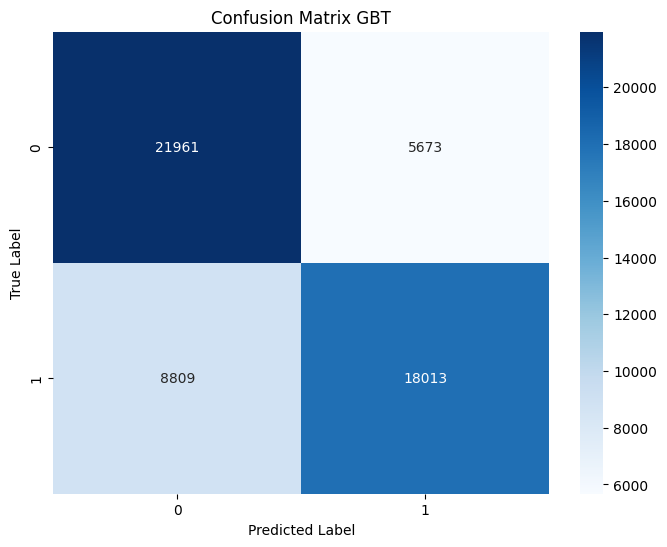

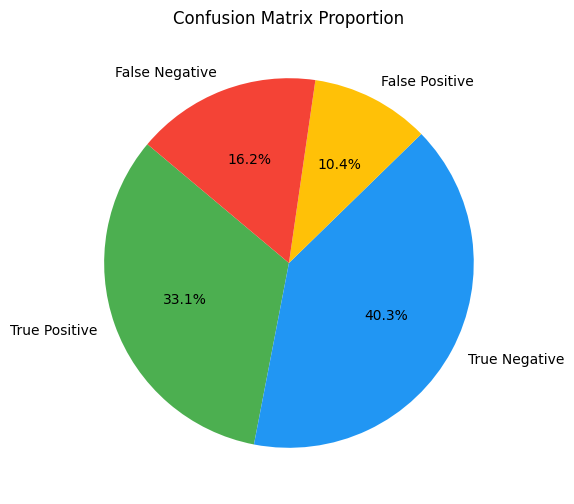

In [ ]:
# Cast 'LUNG_CANCER' column to DoubleType
predictionsGBT = prediction_gbt.withColumn('cardio', col('cardio').cast('double'))

# Mengambil kolom label dan prediksi sebagai RDD untuk MulticlassMetrics
predictionAndLabelsGBT = predictionsGBT.select('prediction', 'cardio').rdd

# Inisialisasi MulticlassMetrics
metricsGBT = MulticlassMetrics(predictionAndLabelsGBT)

# Mendapatkan matriks konfusi
confusion_matrixGBT = metricsGBT.confusionMatrix().toArray()

# Konversi matriks konfusi menjadi DataFrame
confusion_matrix_GBT = pd.DataFrame(confusion_matrixGBT, columns=[str(i) for i in range(confusion_matrixGBT.shape[1])])

# Plot confusion matrix menggunakan seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix_GBT, annot=True, fmt="g", cmap="Blues", xticklabels=[0, 1], yticklabels=[0, 1])
plt.title('Confusion Matrix GBT')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()
plt.show()

true_positive = int(confusion_matrix_GBT.iloc[1, 1])
true_negative = int(confusion_matrix_GBT.iloc[0, 0])
false_positive = int(confusion_matrix_GBT.iloc[0, 1])
false_negative = int(confusion_matrix_GBT.iloc[1, 0])

labels = ['True Positive', 'True Negative', 'False Positive', 'False Negative']
sizes = [true_positive, true_negative, false_positive, false_negative]
colors = ['#4CAF50', '#2196F3', '#FFC107', '#F44336']

# Tampilkan pie chart
plt.figure(figsize=(8, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=colors)
plt.title('Confusion Matrix Proportion')
plt.show()

Hypertune RFC & GBT

In [ ]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Define a parameter grid
param_grid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [10, 20, 30]) \
    .addGrid(rf.maxDepth, [5, 10, 15]) \
    .build()

# Create a cross-validator
cross_val = CrossValidator(estimator=pipeline_rf,
                           estimatorParamMaps=param_grid,
                           evaluator=evaluator_f1_rf,
                           numFolds=3)  # You can adjust the number of folds as needed

# Fit the model using cross-validation
cv_model = cross_val.fit(train2)

# Make predictions on the test set
predictionCV = cv_model.transform(train2)

# Evaluate Accuracy and F1-Score on the test set
accuracy_cv = evaluator_accuracy_rf.evaluate(predictionCV)
f1_score_cv = evaluator_f1_rf.evaluate(predictionCV)

print(f'Tuned Test Accuracy: {accuracy_cv:.2%}')
print(f'Tuned Test F1-Score: {f1_score_cv:.2%}')

# Print the best hyperparameters
best_params = cv_model.bestModel.stages[-1].extractParamMap()
print("Best Hyperparameters:")
for param, value in best_params.items():
    print(f"{param.name}: {value}")


Tuned Test Accuracy: 74.15%
Tuned Test F1-Score: 74.04%
Best Hyperparameters:
bootstrap: True
cacheNodeIds: False
checkpointInterval: 10
featureSubsetStrategy: auto
featuresCol: features
impurity: gini
labelCol: cardio
leafCol: 
maxBins: 32
maxDepth: 10
maxMemoryInMB: 256
minInfoGain: 0.0
minInstancesPerNode: 1
minWeightFractionPerNode: 0.0
numTrees: 30
predictionCol: prediction
probabilityCol: probability
rawPredictionCol: rawPrediction
seed: 8216338240262157649
subsamplingRate: 1.0


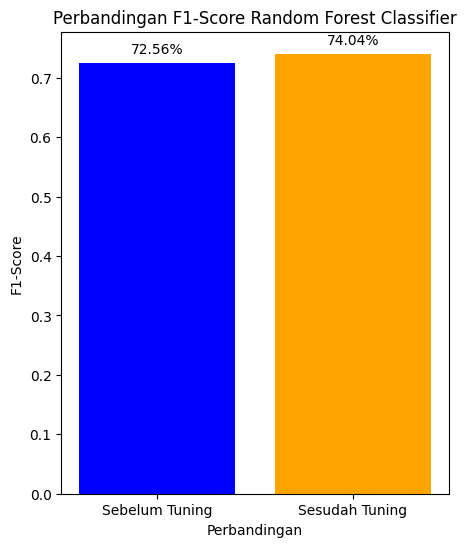

In [ ]:
import matplotlib.pyplot as plt

# F1-Score before tuning for Random Forest
f1_score_before_tuning_RF = [f1_score_rf]  # Replace with the actual F1-Score before tuning

# F1-Score after tuning for Random Forest
f1_score_after_tuning_RF = [f1_score_cv]  # Replace with the actual F1-Score after tuning

# Model names
model_name_RF = ['Sebelum Tuning', 'Sesudah Tuning']  # Adjust with appropriate model names

# Plotting
plt.figure(figsize=(5, 6))
plt.bar(model_name_RF, [max(f1_score_before_tuning_RF), max(f1_score_after_tuning_RF)], color=['blue', 'orange'])

# Adding labels and title
plt.xlabel('Perbandingan')
plt.ylabel('F1-Score')
plt.title('Perbandingan F1-Score Random Forest Classifier')

# Displaying F1-Score values above the bars
for i, value in enumerate([max(f1_score_before_tuning_RF), max(f1_score_after_tuning_RF)]):
    plt.text(i, value + 0.01, f'{value:.2%}', ha='center', va='bottom')

# Show the plot
plt.show()


In [ ]:
paramGrid = (ParamGridBuilder()
             .addGrid(gbt.maxDepth, [5, 10, 15])
             .addGrid(gbt.maxBins, [16, 32, 64, 128])
             .addGrid(gbt.stepSize, [0.1, 0.01])
             .build())

crossval = CrossValidator(estimator=pipeline_gbt,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator_accuracy_gbt,
                          numFolds=3)

cvModel = crossval.fit(train2)

best_model_gbt = cvModel.bestModel

prediction_best_gbt = best_model_gbt.transform(train2)

accuracy_best_gbt = evaluator_accuracy_gbt.evaluate(prediction_best_gbt)
f1_score_best_gbt = evaluator_f1_gbt.evaluate(prediction_best_gbt)

# Evaluate the model
print(f'Best Model Test Accuracy: {accuracy_best_gbt:.2%}')
print(f'Best Model Test F1-Score: {f1_score_best_gbt:.2%}')
# Best hyperparameters
print(f'Best Model Parameters: {best_model_gbt.stages[-1].extractParamMap()}')

Best Model Test Accuracy: 73.43%
Best Model Test F1-Score: 73.33%
Best Model Parameters: {Param(parent='GBTClassifier_75df67efd6e2', name='cacheNodeIds', doc='If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval.'): False, Param(parent='GBTClassifier_75df67efd6e2', name='checkpointInterval', doc='set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext.'): 10, Param(parent='GBTClassifier_75df67efd6e2', name='featureSubsetStrategy', doc="The number of features to consider for splits at each tree node. Supported options: 'auto' (choose automatically for task: If numTrees == 1, set to 'a

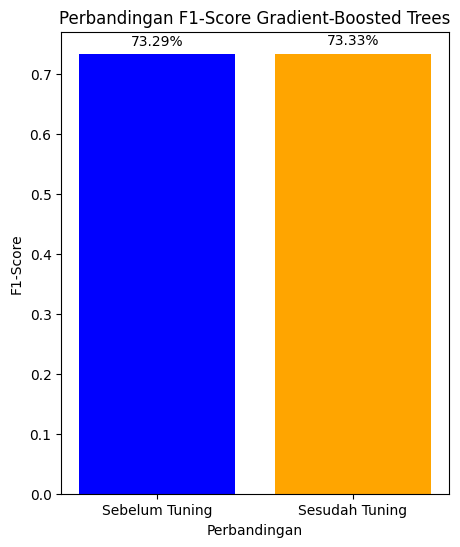

In [ ]:
import matplotlib.pyplot as plt

# F1-Score sebelum tuning
f1_score_before_tuning_GBT = [f1_score_gbt]

# F1-Score setelah tuning
f1_score_after_tuning_GBT = [f1_score_best_gbt]

# Nama model atau metode
model_name_GBT = ['Sebelum Tuning', 'Sesudah Tuning']

# Plotting
plt.figure(figsize=(5, 6))
plt.bar(model_name_GBT, [max(f1_score_before_tuning_GBT), max(f1_score_after_tuning_GBT)], color=['blue', 'orange'])

# Menambahkan label dan judul
plt.xlabel('Perbandingan')
plt.ylabel('F1-Score')
plt.title('Perbandingan F1-Score Gradient-Boosted Trees')

# Menampilkan nilai F1-Score di atas batang
for i, value in enumerate([max(f1_score_before_tuning_GBT), max(f1_score_after_tuning_GBT)]):
    plt.text(i, value + 0.01, f'{value:.2%}', ha='center', va='bottom')

# Menampilkan plot
plt.show()


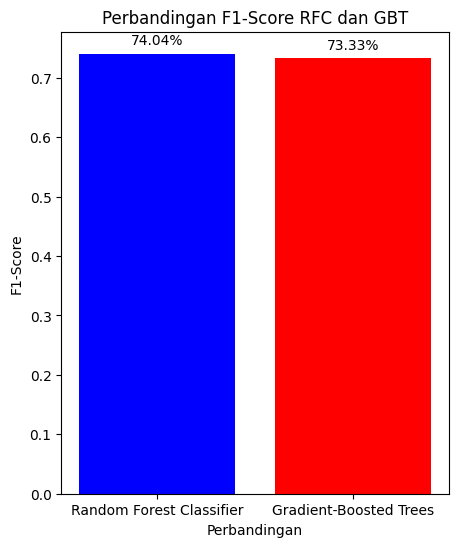

In [ ]:
# Nama model atau metode
model_name_compare = ['Random Forest Classifier', 'Gradient-Boosted Trees']

# Plotting
plt.figure(figsize=(5, 6))
plt.bar(model_name_compare, [max(f1_score_after_tuning_RF), max(f1_score_after_tuning_GBT)], color=['blue', 'red'])

# Menambahkan label dan judul
plt.xlabel('Perbandingan')
plt.ylabel('F1-Score')
plt.title('Perbandingan F1-Score RFC dan GBT')

# Menampilkan nilai F1-Score di atas batang
for i, value in enumerate([max(f1_score_after_tuning_RF), max(f1_score_after_tuning_GBT)]):
    plt.text(i, value + 0.01, f'{value:.2%}', ha='center', va='bottom')

# Menampilkan plot
plt.show()


Model Terbaik
Random Forest

In [ ]:
best_model_rf = cv_model.bestModel
best_rf_classifier = best_model_rf.stages[-1]
print("Best Random Forest Model:")
print(f"Num Trees: {best_rf_classifier.getNumTrees}")
print(f"Max Depth: {best_rf_classifier.getMaxDepth()}")

Best Random Forest Model:
Num Trees: 30
Max Depth: 10
